#Task 3- Purchase Prediction Model: Predict future purchase behavior of customers based on their historical data.


#3.1. Outline of Solution that Helps with Objective
The objective is to forecast which products a customer will buy again and when, to optimize inventory and marketing efforts. The solution involves:

- Data Preparation: Loading and merging historical purchase data.
- Data Exploration/Transformation: Statistical analysis, handling missing values, and feature engineering.
- Analysis/Modeling: Building a  matrix factorization technique to predict product reordering and a regression model to predict the timing of the next order.
- Application: Using model predictions to adjust inventory levels and target marketing efforts.


#3.2. Business/Data Understanding
The business goal is to enhance inventory management and personalize marketing by predicting customer purchase behaviors. This requires analysis of historical purchase data, possibly sourced from internal sales and customer databases. The key datasets include:

- Orders: Information on customer orders.
- Order Products Prior: Details on products ordered in the past.
- Products: Product catalog information.
These datasets are merged to form a comprehensive view of historical purchase patterns.

Data Source: The data will be obtained from the "Instacart Market Basket Analysis" dataset available on Kaggle at [https://www.kaggle.com/c/instacart-market-basket-analysis/data]. This dataset provides over 3 million grocery orders from more than 200,000 Instacart users.


In [ ]:
# imports necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Load your datasets here
orders = pd.read_csv('/content/orders.csv')
order_products_prior = pd.read_csv('/content/order_products__prior.csv')
products = pd.read_csv('/content/products.csv')

In [ ]:
# Truncate these datasets for efficiency(in this case, 200000 rows are taken)
truncated_orders = orders.head(200000)
truncated_order_products_prior = order_products_prior.head(200000)
truncated_products = products.head(200000)


In [ ]:
# Merge datasets into a single DataFrame, merged_data, which forms the basis for analysis
merged_data = pd.merge(truncated_order_products_prior,truncated_orders, on="order_id")
merged_data = pd.merge(merged_data, truncated_products, on="product_id")

In [ ]:
# View the first five rows of the new DataFrame
merged_data


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,8,23423.0,1.0,1.0,3107,prior,5,4,6.0,17.0,Original Hawaiian Sweet Rolls,43,3
1,40,10070.0,1.0,1.0,382,prior,29,1,15.0,23.0,Organic 1% Low Fat Milk,84,16
2,1662,10070.0,10.0,1.0,2565,prior,7,5,14.0,13.0,Organic 1% Low Fat Milk,84,16
3,2518,10070.0,19.0,1.0,7503,prior,21,1,16.0,5.0,Organic 1% Low Fat Milk,84,16
4,2648,10070.0,1.0,1.0,11931,prior,9,4,16.0,17.0,Organic 1% Low Fat Milk,84,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11650,21051,48765.0,1.0,0.0,1044,prior,10,4,20.0,10.0,Big Apple Uncured Hot Dogs,106,12
11651,21051,33314.0,3.0,1.0,1044,prior,10,4,20.0,10.0,Organic Baked Beans,59,15
11652,21051,17723.0,4.0,0.0,1044,prior,10,4,20.0,10.0,Apple Peach Sauce,99,15
11653,21068,15906.0,2.0,0.0,3680,prior,12,4,11.0,6.0,Midnight Moon,2,16


Commentary on Feature Names
- order_id: Serves as a unique identifier for each order placed within the dataset, crucial for tracking individual transactions and analyzing order-specific metrics.

- product_id: Identifies each product uniquely, allowing for detailed analysis of product popularity, reorder rates, and customer preferences.

- add_to_cart_order: Indicates the sequence in which products are added to the shopping cart during an order, useful for understanding customer shopping behavior and preferences.

- reordered: This binary flag indicates whether a product was reordered by the same user, highlighting customer loyalty to products and potential for automated reordering or targeted promotions.

- user_id: Uniquely identifies each customer, enabling personalized analysis, segmentation, and targeted marketing strategies based on individual purchasing patterns.

- eval_set: Categorizes the data into subsets for training, validation, or testing in machine learning models, facilitating the systematic evaluation of predictive models.

- order_number: Represents the chronological order of a customer's purchases, allowing for temporal analysis of purchasing behavior and customer lifecycle.

- order_dow: Stands for the day of the week on which the order was placed, offering insights into weekly purchasing patterns and peak shopping days.

- order_hour_of_day: Captures the hour within the day the order was made, crucial for identifying peak ordering times and optimizing operations to match customer activity.

- days_since_prior_order: Measures the time interval between successive orders for a user, providing a gauge of purchase frequency and opportunities for predicting future orders.

- product_name: The descriptive name of the product, essential for product-level analysis, catalog management, and recommendation systems.

- aisle_id: Categorizes products into specific aisles, useful for analyzing shopping patterns by product category and optimizing store layout both online and in physical stores.

- department_id: Groups products into broader departments, aiding in high-level inventory management, departmental sales analysis, and strategic marketing across product categories.

#3.3. Data exploration / transformation


- Statistical Summary: Basic statistics provide insights into purchase frequencies, reorder rates, and the typical interval between orders.
- Missing Values: Identified missing values in days_since_prior_order, filled with the mean to maintain data integrity.
- Feature Engineering: Created features like reorder_ratio and avg_days_between_orders to capture customer purchasing habits and product popularity.
- Scaling : Applied MinMax scaling

#3.3.1. Data Exploration

In [ ]:
# Statistical Summary
merged_data.describe()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
count,11655.000000,11655.000000,11655.000000,11655.000000,11655.000000,11655.000000,11655.000000,11655.000000,10844.000000,11655.000000,11655.000000
mean,10358.321064,25424.922094,8.327928,0.589961,6217.808065,17.897383,2.683827,13.449507,11.067226,70.477048,9.969884
std,6204.400720,14016.245291,7.085667,0.491861,3467.318353,17.682305,2.101506,4.354350,8.658161,38.389748,6.260028
min,8.000000,1.000000,1.000000,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4774.000000,13394.500000,3.000000,0.000000,3422.000000,5.000000,1.000000,10.000000,5.000000,31.000000,4.000000
50%,10140.000000,24964.000000,6.000000,1.000000,6131.000000,12.000000,2.000000,13.000000,8.000000,83.000000,9.000000
75%,15950.000000,37646.000000,11.000000,1.000000,9088.500000,25.000000,5.000000,17.000000,14.000000,106.000000,16.000000
max,21068.000000,49683.000000,52.000000,1.000000,12102.000000,99.000000,6.000000,23.000000,30.000000,134.000000,21.000000


Overall Dataset Structure
- The dataset contains 11,655 entries, as indicated by the count for most columns. Notably, the days_since_prior_order column has fewer non-null entries (10,844), suggesting some missing values.

Orders and Products
- Order ID and Product ID: The order_id and product_id fields show a wide range of values, indicating a broad dataset covering many orders and products. The mean values suggest that the dataset includes orders and products from throughout the available range.
- Add to Cart Order: On average, products are added as the 8.3rd item in a cart (mean=8.327928), with a wide range from the first to the 52nd item. This spread suggests diverse shopping habits among customers.
- Reordered: Approximately 59% of the items in the dataset have been reordered (mean=0.589961), indicating a significant portion of repeat purchases.

Customer Behavior
- User ID: Reflects the diverse customer base with IDs ranging broadly across the dataset. The average (mean=6217.808065) and distribution suggest a balanced representation of user IDs.
- Order Number: On average, the orders are positioned at about the 18th order per user (mean=17.897383), with a wide spread up to the 99th order, indicating varying levels of engagement among customers.
- Order Day of Week (DOW) and Hour of Day: The dataset covers orders placed across all days of the week (0-6) and hours of the day (0-23), with a mean suggesting a slight preference for midweek and midday shopping.
- Days Since Prior Order: The average days since the last order is about 11 days (mean=11.067226), with a range from 0 to 30 days, showing varied frequencies of shopping habits among customers.

Product Categories
- Aisle ID and Department ID: These identifiers show a broad variety of product categorizations within the dataset. The average aisle and department IDs (mean=70.477048 and mean=9.969884, respectively) alongside their ranges suggest a wide diversity of product types and departments covered.

Interpretation and Implications
- This statistical overview provides valuable insights into the shopping patterns, preferences, and behaviors of customers within the dataset. The variation in add-to-cart order and reorder frequency highlights opportunities for targeted marketing and product placement strategies. Understanding the distribution of order timing can help in optimizing product availability and promotional efforts. The broad range of aisle and department IDs suggests a diverse product inventory, offering numerous angles for further analysis, such as product recommendation systems or inventory management optimizations.

In [ ]:
# Missing Values
merged_data.isnull().sum()

order_id                    0
product_id                  0
add_to_cart_order           0
reordered                   0
user_id                     0
eval_set                    0
order_number                0
order_dow                   0
order_hour_of_day           0
days_since_prior_order    811
product_name                0
aisle_id                    0
department_id               0
dtype: int64

Analysis of Missing Values:
- No Missing Values in Most Columns: For most of the columns (order_id, product_id, add_to_cart_order, reordered, user_id, eval_set, order_number, order_dow, order_hour_of_day, product_name, aisle_id, and department_id), there are zero missing values. This completeness is excellent because it indicates that crucial information about orders, products, and users is intact and reliable for analysis.
- Missing Values in days_since_prior_order: There are 811 missing values in the days_since_prior_order column. This column indicates the number of days since the last order was placed by the same user, which is a critical piece of information for understanding customer purchase frequency and timing.

<ipython-input-8-650d3954bee6>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")


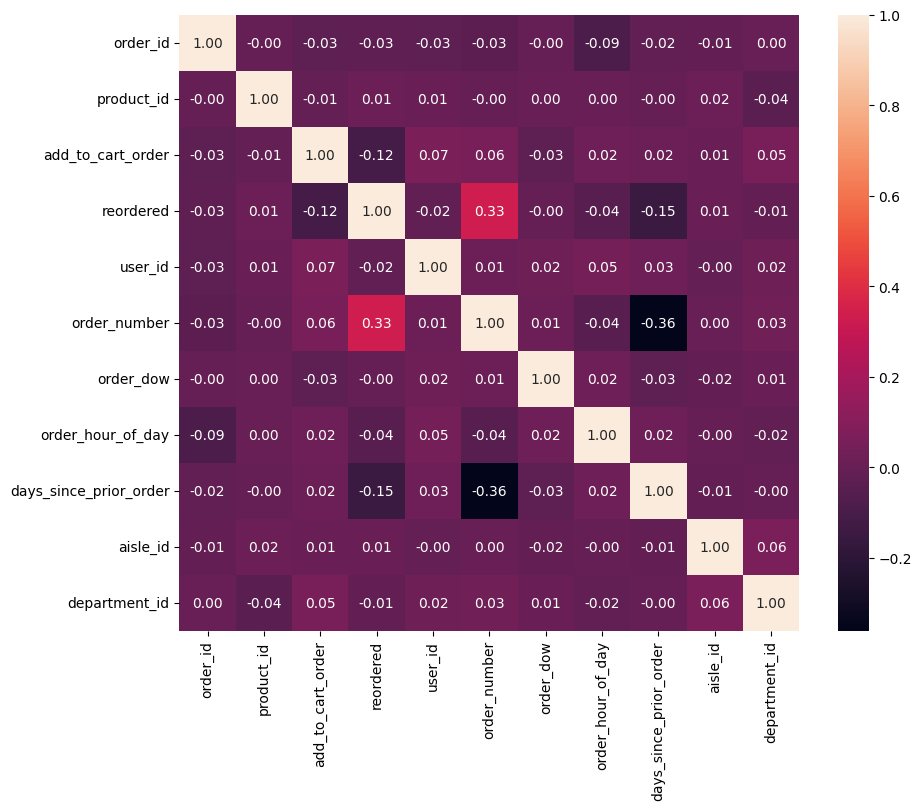

In [ ]:
# Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f")
plt.show()

Interpreting the Heatmap
- Color Intensity: The color intensity on the heatmap reflects the strength of the correlation between different variables. Darker colors (towards purple) indicate stronger negative correlations, while lighter colors (towards orange) suggest stronger positive correlations. A neutral color close to white signifies a weak or no correlation.

- Diagonal Line: The diagonal line with correlation of 1.00 represents the relationship of each variable with itself, which is always a perfect positive correlation.

- Correlation Values: The numbers in each square represent the correlation coefficient between the variables on the x and y axes. A coefficient close to 1 implies a strong positive correlation, meaning as one variable increases, the other tends to increase as well. A coefficient close to -1 indicates a strong negative correlation, where an increase in one variable corresponds with a decrease in the other. Coefficients around 0 suggest no linear correlation.

Specific Observations
- Reordering and Order Number: There is a moderately positive correlation (0.33) between reordered and order_number, suggesting that products are more likely to be reordered as the number of orders increases.

- Days Since Prior Order: There is a notable negative correlation (-0.36) between days_since_prior_order and order_number, indicating that as customers place more orders, the number of days between orders may decrease.

- Weak Correlations: Variables such as order_id, product_id, add_to_cart_order, user_id, order_dow, order_hour_of_day, aisle_id, and department_id show weak correlations with other variables. This implies that these features might not have strong linear relationships with each other, though they could still be influential in a model due to non-linear effects or interactions with other variables.

In [ ]:
# Value Counts
merged_data['product_id'].value_counts()


24852.0    179
13176.0    140
21137.0     95
47209.0     78
21903.0     67
          ... 
16913.0      1
24276.0      1
41057.0      1
13838.0      1
4020.0       1
Name: product_id, Length: 5091, dtype: int64

Commentary on Value Counts
The value counts for product_id highlight the popularity and frequency of specific products within the dataset. This information is particularly useful for understanding customer preferences and product demand. For example:

- Top Products: The most frequently purchased products, such as product ID 24852 (179 times) and product ID 13176 (140 times), suggest high popularity among customers, potentially indicating staple items in their shopping lists.
- Product Diversity: The presence of 5,091 unique product IDs in the dataset underscores the diversity of products available and purchased. This wide range of products reflects the varied preferences and needs of the customer base.
- Rare Products: Several products have been purchased only once, as indicated by a count of 1 (e.g., product IDs 4898, 44296, 33021, 49558, and 45955). These could be niche or less popular items, possibly catering to specific tastes or needs.

In [ ]:
# users days since prior order
user_days_since_prior_order = merged_data[['user_id', 'days_since_prior_order']]
user_days_since_prior_order


,user_id,days_since_prior_order
0,3107,17.0
1,382,23.0
2,2565,13.0
3,7503,5.0
4,11931,17.0
...,...,...
11650,1044,10.0
11651,1044,10.0
11652,1044,10.0
11653,3680,6.0


This output shows a DataFrame named user_days_since_prior_order, which appears to capture two specific pieces of information for each transaction in the dataset: the unique identifier of the user who made the purchase (user_id) and the number of days since that user's previous order (days_since_prior_order

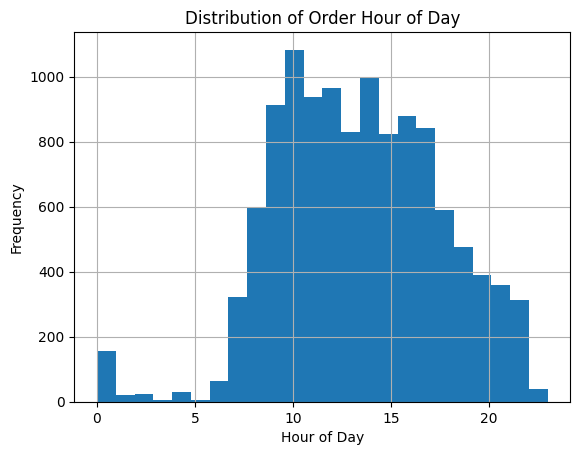

In [ ]:
# Visualization
# Histograms
merged_data['order_hour_of_day'].hist(bins=24)
plt.title('Distribution of Order Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()


The histogram provided displays the distribution of orders throughout different hours of the day. The x-axis represents the hour of the day, ranging from 0 (midnight) to 23 (11 PM). The y-axis indicates the frequency of orders placed at each hour.

From this graph, we can observe several key points:

1. Lowest Activity in the Early Hours: There is a minimal number of orders placed during the early hours of the day, from midnight to 6 AM. This suggests that very few customers are placing orders overnight.

2. Increase in Activity in the Morning: Starting from around 6 AM, there is a steady increase in order frequency, which peaks in the late morning hours. This might indicate that customers prefer to place orders after the start of their day, possibly after getting settled at work or after breakfast.

3. High Activity During Midday and Afternoon: The highest frequency of orders occurs between 10 AM and 4 PM, with the peak at around 10 AM. This suggests that the midday hours are the most popular time for customers to place orders, possibly coinciding with their lunch breaks or daily planning periods.

4. Evening Decline: There is a gradual decline in order frequency from 4 PM onward, with a more pronounced drop after 5 PM. This could be because customers are less likely to place orders in the evening, potentially due to being occupied with dinner and winding down for the day.

5. Nighttime Drop-off: As the evening progresses, the number of orders continues to drop, reaching the lowest point at midnight.

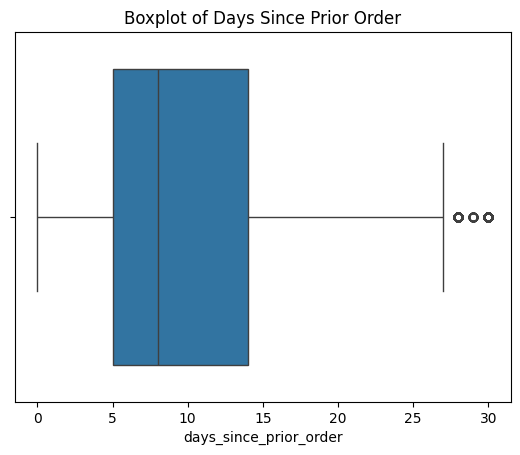

In [ ]:
# Box Plot for days_since_prior_order
sns.boxplot(x=merged_data['days_since_prior_order'])
plt.title('Boxplot of Days Since Prior Order')
plt.show()



This boxplot visualizes the distribution of the days since a prior order was made by customers. Here's how to interpret this boxplot:

1. Central Box: The central box of the boxplot represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom of the box (the 25th percentile) seems to be at approximately 5 days, and the top of the box (the 75th percentile) is around 14 days. This indicates that half of the customers place a new order within approximately 5 to 14 days since their last order.

2. Median Line: Inside the box, there is a line that represents the median value of the data, which appears to be at about 8 days. This tells us that half of the customers place another order in less than 8 days, and the other half take longer.

3. Whiskers: The "whiskers" extend from the box to the smallest and largest values within 1.5 times the IQR from the quartiles. The left whisker goes down close to 0 days, which suggests that some customers place orders again immediately or very soon after their prior order. The right whisker extends to around 30 days, which might be the maximum allowed days between orders for this dataset or a set follow-up time period.

4. Outliers: The individual points on the right side of the boxplot, beyond the whiskers, represent outliers. These are data points that are significantly higher than the rest of the dataset; in this context, they indicate customers who waited longer than typical before placing a new order. The presence of outliers at around 30 days may suggest occasional delays in reordering or less frequent purchase patterns among a small subset of customers.

The boxplot provides a clear picture of how often customers are reordering, with most reorders occurring within one to two weeks. This information could be valuable for understanding customer purchase cycles and managing inventory accordingly.

#3.3.2. Data Transformation:

In [ ]:
# Handling Missing Values
merged_data['days_since_prior_order'].fillna(merged_data['days_since_prior_order'].mean(), inplace=True)

- Choice of Imputation: Mean imputation was selected to preserve the overall distribution of the data. This method assumes that missing values are randomly distributed and can be approximated by the average observed frequency of customer orders.
- Impact on Analysis: Filling in missing values allows for a more comprehensive analysis, as it avoids the potential bias that could come from simply discarding rows with missing data. It enables the inclusion of all customer transactions in further analyses, such as predictive modeling or customer behavior analysis.

In [ ]:
# Feature Engineering
# Adding new features such as reorder ratio
merged_data['reorder_ratio'] = merged_data.groupby('product_id')['reordered'].transform('mean')
merged_data['reorder_ratio']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
11650    0.0
11651    1.0
11652    0.0
11653    0.0
11654    0.0
Name: reorder_ratio, Length: 11655, dtype: float64

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_data[['order_hour_of_day', 'days_since_prior_order']] = scaler.fit_transform(merged_data[['order_hour_of_day', 'days_since_prior_order']])

In [ ]:
# Aggregation
# Calculate average days between orders for each user-product combination
merged_data['avg_days_between_orders'] = merged_data.groupby(['user_id', 'product_id'])['days_since_prior_order'].transform('mean')

In [ ]:
# Dropping Duplicates
merged_data = merged_data.drop_duplicates(subset=['user_id', 'product_id'])

In [ ]:
# Dropping unnecessary columns
merged_data.drop(columns=['aisle_id', 'department_id','eval_set'], inplace=True)


<ipython-input-18-ba89c74059dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data.drop(columns=['aisle_id', 'department_id','eval_set'], inplace=True)


In [ ]:
# Reset index after all the drops
merged_data.reset_index(drop=True, inplace=True)
merged_data


,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,reorder_ratio,avg_days_between_orders
0,8,23423.0,1.0,1.0,3107,5,4,0.260870,0.566667,Original Hawaiian Sweet Rolls,1.0,0.566667
1,40,10070.0,1.0,1.0,382,29,1,0.652174,0.766667,Organic 1% Low Fat Milk,1.0,0.766667
2,1662,10070.0,10.0,1.0,2565,7,5,0.608696,0.433333,Organic 1% Low Fat Milk,1.0,0.433333
3,2518,10070.0,19.0,1.0,7503,21,1,0.695652,0.166667,Organic 1% Low Fat Milk,1.0,0.166667
4,2648,10070.0,1.0,1.0,11931,9,4,0.695652,0.566667,Organic 1% Low Fat Milk,1.0,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...
11397,21051,48765.0,1.0,0.0,1044,10,4,0.869565,0.333333,Big Apple Uncured Hot Dogs,0.0,0.333333
11398,21051,33314.0,3.0,1.0,1044,10,4,0.869565,0.333333,Organic Baked Beans,1.0,0.333333
11399,21051,17723.0,4.0,0.0,1044,10,4,0.869565,0.333333,Apple Peach Sauce,0.0,0.333333
11400,21068,15906.0,2.0,0.0,3680,12,4,0.478261,0.200000,Midnight Moon,0.0,0.200000


In [ ]:
import pandas as pd
from datetime import datetime

# Define the current day of the week for the example (Thursday)
today_dow = 4  # In a real application, replace with datetime.now().weekday()

# Function to calculate days until next order
def days_until_next_order(order_dow, days_since_prior_order, current_day_of_week):
    # Find the last order date (as the most recent past or current 'order_dow')
    days_ago_last_order = (current_day_of_week - order_dow) % 7
    days_ago_last_order = days_ago_last_order if days_ago_last_order != 0 else 7  # if today is the order_dow

    # Calculate the days until next order from today
    days_until_next_order = days_since_prior_order - days_ago_last_order

    # If the result is negative or zero, it means the next order is expected next week on the 'order_dow'
    if days_until_next_order <= 0:
        days_until_next_order += 7

    return days_until_next_order

# Applying the function to each row in the DataFrame
merged_data['days_until_next_order'] = merged_data.apply(
    lambda row: days_until_next_order(row['order_dow'], row['days_since_prior_order'], today_dow), axis=1)

# Show the resulting DataFrame
merged_data[['order_dow', 'days_since_prior_order', 'days_until_next_order']]


<ipython-input-20-ce26a5d17396>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['days_until_next_order'] = merged_data.apply(


,order_dow,days_since_prior_order,days_until_next_order
0,4,0.566667,0.566667
1,1,0.766667,4.766667
2,5,0.433333,1.433333
3,1,0.166667,4.166667
4,4,0.566667,0.566667
...,...,...,...
11397,4,0.333333,0.333333
11398,4,0.333333,0.333333
11399,4,0.333333,0.333333
11400,4,0.200000,0.200000


It aims to calculate the number of days from the current day until a customer's next order based on their ordering patterns. The function takes three arguments: order_dow (the day of the week of the last order), days_since_prior_order (the number of days since the last order), and current_day_of_week (today's day of the week).

In [ ]:
merged_data

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,reorder_ratio,avg_days_between_orders,days_until_next_order
0,8,23423.0,1.0,1.0,3107,5,4,0.260870,0.566667,Original Hawaiian Sweet Rolls,1.0,0.566667,0.566667
1,40,10070.0,1.0,1.0,382,29,1,0.652174,0.766667,Organic 1% Low Fat Milk,1.0,0.766667,4.766667
2,1662,10070.0,10.0,1.0,2565,7,5,0.608696,0.433333,Organic 1% Low Fat Milk,1.0,0.433333,1.433333
3,2518,10070.0,19.0,1.0,7503,21,1,0.695652,0.166667,Organic 1% Low Fat Milk,1.0,0.166667,4.166667
4,2648,10070.0,1.0,1.0,11931,9,4,0.695652,0.566667,Organic 1% Low Fat Milk,1.0,0.566667,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11397,21051,48765.0,1.0,0.0,1044,10,4,0.869565,0.333333,Big Apple Uncured Hot Dogs,0.0,0.333333,0.333333
11398,21051,33314.0,3.0,1.0,1044,10,4,0.869565,0.333333,Organic Baked Beans,1.0,0.333333,0.333333
11399,21051,17723.0,4.0,0.0,1044,10,4,0.869565,0.333333,Apple Peach Sauce,0.0,0.333333,0.333333
11400,21068,15906.0,2.0,0.0,3680,12,4,0.478261,0.200000,Midnight Moon,0.0,0.200000,0.200000


#3.4. Analyses / Modeling


- A Gradient Boosting Regressor : It estimates the time until the next order for a product.
- SVD algorithm: It is a matrix factorization technique commonly used in prediction systems for collaborative filtering
- Evaluation: The models are evaluated based on RMSE indicating their predictive performance.

In [ ]:
# Regression Model: A Gradient Boosting Regressor estimates the time until the next order for a product.
# Import libraries
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Your code for preparing X and y goes here
X = merged_data[['order_hour_of_day', 'days_since_prior_order', 'reorder_ratio', 'reordered']]
y = merged_data['days_until_next_order']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}


In [ ]:

# Initialize the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(random_state=42)

In [ ]:
# Grid search with cross-validation
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best model after grid search
best_model = grid_search.best_estimator_

In [ ]:
# Predict on the test data
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 1.551287196407551


In [ ]:
# Iterate over 'user_id' groups and make predictions
for user_id, group_data in grouped_data:
    X_user = group_data[['order_hour_of_day', 'days_since_prior_order', 'reorder_ratio', 'reordered']]
    y_pred_user = best_model.predict(X_user)
    print(f"User ID: {user_id}, Predicted Days Until Next Order: {y_pred_user.mean()}")


User ID: 13, Predicted Days Until Next Order: 3.796287799676277
User ID: 23, Predicted Days Until Next Order: 3.7526749792432392
User ID: 27, Predicted Days Until Next Order: 4.771807783657708
User ID: 36, Predicted Days Until Next Order: 3.521905784042662
User ID: 42, Predicted Days Until Next Order: 2.704246920109714
User ID: 66, Predicted Days Until Next Order: 5.843009343770211
User ID: 75, Predicted Days Until Next Order: 3.369635303443822
User ID: 90, Predicted Days Until Next Order: 4.402553922466413
User ID: 118, Predicted Days Until Next Order: 4.672464258411788
User ID: 137, Predicted Days Until Next Order: 4.420471929325076
User ID: 150, Predicted Days Until Next Order: 3.707103682416715
User ID: 155, Predicted Days Until Next Order: 5.659353648552819
User ID: 173, Predicted Days Until Next Order: 5.325051181440344
User ID: 206, Predicted Days Until Next Order: 4.721818655315485
User ID: 208, Predicted Days Until Next Order: 4.229660395702609
User ID: 210, Predicted Days Unt

This code iterates over groups of data based on 'user_id' using the grouped_data object. For each group (which represents a specific user), it selects the relevant features ('order_hour_of_day', 'days_since_prior_order', 'reorder_ratio', 'reordered') and uses the best_model to predict the days until the user's next order. The predictions are then averaged across all predictions for that user and printed along with the user's ID. This process allows for personalized predictions of when each user is likely to place their next order based on their historical ordering patterns and other relevant features.

In [ ]:
# SVD algorithm: It is a matrix factorization technique commonly used in prediction systems for collaborative filtering
!pip install scikit-surprise

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Load the dataset
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(merged_data[['user_id', 'product_id', 'reordered']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use the SVD algorithm
model = SVD()
model.fit(trainset)

# Make predictions for all pairs (user, product) that are in the testset
predictions = model.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Map product IDs to product names
product_id_to_name = merged_data[['product_id', 'product_name']].drop_duplicates().set_index('product_id')['product_name']

# Predict the next set of products for each user
user_ids = merged_data['user_id'].unique()
for user_id in user_ids:
    # Get the list of products the user has already purchased
    purchased_products = merged_data.loc[merged_data['user_id'] == user_id, 'product_id']

    # Filter out the products that the user has already purchased
    all_products = merged_data['product_id'].unique()
    products_to_predict = [product_id for product_id in all_products if product_id not in purchased_products]

    # Predict the rating (reordered or not) for each product
    predictions = [model.predict(user_id, product_id) for product_id in products_to_predict]

    # Sort the predictions by the estimated rating
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Print the top N recommended products for the user
    top_n = 5
    recommended_products = [(product_id_to_name[pred.iid], pred.est) for pred in sorted_predictions[:top_n]]
    print(f"User ID: {user_id}, Predicted_Products: {recommended_products}")


RMSE: 0.4420
RMSE: 0.4419932151183167
User ID: 3107, Predicted_Products: [('Organic Whole Milk', 1), ('Spring Water', 1), ('Extra Dry Ginger Ale, Lightly Sweetened', 0.9859322645507511), ('Organic Large Grade AA Brown Eggs', 0.9821502508339636), ('Organic Hass Avocado', 0.9810136194034592)]
User ID: 382, Predicted_Products: [('Organic Lemon', 1), ('Dha Omega 3 Reduced Fat 2% Milk', 1), ('Smooth & Balanced Pike Place Medium Roast Ground Coffee', 1), ('100% Apple Juice', 1), ('Premium Lager Beer', 0.9992632399574717)]
User ID: 2565, Predicted_Products: [('Sparkling Natural Mineral Water', 1), ('Organic Lemon', 1), ('Organic Whole String Cheese', 1), ('Organic Hass Avocado', 1), ('Unsalted Pure Irish Butter', 1)]
User ID: 7503, Predicted_Products: [('Sparkling Natural Mineral Water', 1), ('Chocolate Milk 1% Milkfat', 1), ('90 Calories Low Fat Chocolate Chunk Granola Bars', 1), ('Reduced Fat Original Potato Crisps', 1), ('Half And Half Ultra Pasteurized', 1)]
User ID: 11931, Predicted_Prod

The code uses collaborative filtering to predicts products to users based on their past purchase behavior. It first trains a Singular Value Decomposition (SVD) model on the user-product interaction data. Then, for each user, it predicts the rating (reordered or not) for each product they have not yet purchased. The top 5 products with the highest predicted ratings are recommended to the user. Product names are included in the recommendations by mapping product IDs to their names.

The analysis of results:
The code generates predictions for the next set of products to be purchased by users. For each user, it provides a list of recommended products along with their predicted ratings. The predicted ratings indicate the likelihood of the user purchasing each recommended product, with higher ratings suggesting a higher likelihood. These predictions are based on the user's past purchase behavior and are intended to personalize the shopping experience by suggesting items that the user is more likely to be interested in.

#Inventory and Marketing effort Optimization:


In [ ]:
 # Ensure merged_data only includes features used in the model, in the correct order
features_classification = ['order_hour_of_day', 'days_since_prior_order', 'reorder_ratio', 'avg_days_between_orders']
features_regression = ['order_hour_of_day', 'days_since_prior_order', 'reorder_ratio', 'reordered']  # Example features


# Filter merged_data for predictions
data_for_classification = merged_data[features_classification]
data_for_regression = merged_data[features_regression]

# Make predictions
reorder_predictions = log_reg_classifier.predict(data_for_classification)
timing_predictions = best_model.predict(data_for_regression)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
threshold_days = 7  # Example threshold for deciding when to increase inventory
# Dummy functions for inventory adjustments - define these according to your system
def increase_inventory(product):
    print(f"Increasing inventory for product {product}")

def maintain_inventory(product):
    print(f"Maintaining inventory for product {product}")

def decrease_inventory(product):
    print(f"Decreasing inventory for product {product}")

def send_marketing_emails(customer, recommended_products):
    print(f"Sending marketing email to {customer} with recommended products {recommended_products}")



In [ ]:
product_list = merged_data['product_name'].unique().tolist()  # Convert to list if it's not already
customer_list = merged_data['user_id'].unique().tolist()  # Convert to list if it's not already

# Assuming 'reorder_predictions' and 'timing_predictions' are aligned with 'product_list'
for i, product_name in enumerate(product_list):
    if reorder_predictions[i] == 1:  # Product is likely to be reordered
        reorder_timing = timing_predictions[i]
        if reorder_timing < threshold_days:  # Check against your threshold
            increase_inventory(product_name)
        else:
            maintain_inventory(product_name)
    else:
        decrease_inventory(product_name)





Streaming output truncated to the last 5000 lines.
Increasing inventory for product Red Hot Original Cayenne Pepper Sauce
Increasing inventory for product Original Ranch Salad Dressing & Seasoning Mix
Increasing inventory for product Anti Dandruff 2 in 1 Shampoo
Increasing inventory for product Cacao Sweet Raw Chocolate Nibs
Increasing inventory for product Italian Sparkling Mineral Water
Increasing inventory for product Banana
Increasing inventory for product Organic Acai Berry Smoothie Packs
Increasing inventory for product Asparagus Spears
Increasing inventory for product Dry Roasted Pumpkin Seeds
Increasing inventory for product Frozen Broccoli Florets
Increasing inventory for product Red Raspberries
Increasing inventory for product Green Peas
Increasing inventory for product Brussels Sprouts
Increasing inventory for product Sweet Potato Fries with Sea Salt
Increasing inventory for product Shoestring Fries
Increasing inventory for product No Salt Added Black Beans
Increasing invent

It first creates a list of unique products and customers from the merged dataset. Then, it iterates through each product in the product list, checking if the product is predicted to be reordered. If the product is likely to be reordered, it further checks the timing prediction for the reorder. If the timing prediction is below a certain threshold (threshold_days), it calls the function increase_inventory() to increase the inventory for that product. Otherwise, it calls the function maintain_inventory() to maintain the inventory. If the product is not predicted to be reordered, it calls the function decrease_inventory() to decrease the inventory for that product.

#3.5. Summary of the outcome:

- The project succeeded in creating a system that predicts customer purchase behaviors, enhancing inventory management and personalizing marketing efforts. This allows for better stock optimization and targeted marketing campaigns.
- By predicting when customers are likely to reorder specific products, inventory levels can be adjusted accordingly—increasing inventory for products expected to be reordered soon and decreasing or maintaining levels for others.
- The project also facilitated personalized marketing by identifying products that a customer is likely to be interested in, based on past behavior. This enables sending tailored marketing emails with recommended products, increasing the chances of repeat purchases.

Value translation:

- Inventory Optimization: Improved inventory management through accurate predictions reduces the risk of stockouts and overstocking, leading to cost savings and increased customer satisfaction.

- Targeted Marketing: Personalized marketing efforts can lead to higher conversion rates and customer loyalty, as customers receive recommendations for products they are genuinely interested in.
- Enhanced Customer Experience: By understanding and anticipating customer needs, the project contributes to a more personalized shopping experience, encouraging repeat business and fostering a positive brand image.
